# PINN for One Variable Integration

The idea is to use the fact that 
$$
    F(x) = \int f(x) dx
$$
is the solution to the differential equation 
$$
    \frac{dF}{dx} - f = 0
$$

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


## Defnining a general neural network class

In [2]:
class NN(tf.keras.Model):
    def __init__(
            self, 
            num_inputs: int=1,
            num_hidden_layers: int=1,
            num_neurons: int=1,
            activation: str = 'tanh'
    )->None:
        super().__init__()
        self.num_inputs = num_inputs
        self.num_hidden_layers = num_hidden_layers
        self.num_neurons = num_neurons

        NNLayers = [] 
        for _ in range(num_hidden_layers):
            NNLayers.append(tf.keras.layers.Dense(units=num_neurons, activation=activation)) # the hidden layers
        NNLayers.append(tf.keras.layers.Dense(units=1)) # the output layer

        self.NNLayers = NNLayers

    def call(
            self,
            input: tf.Tensor
    )->tf.Tensor: # the neural network call implements the forward call, where it runs the input through the first layer, and then feeds the output of the first layer to the second layer and so on
        output = tf.reshape(input, shape=(-1, self.num_inputs))
        for layer in self.NNLayers:
            output = layer(output)
        return output


## Problem specific defninition of the loss function

In [3]:
X_BOUNDARY=0.0
FUN_BOUNDARY=0.0
NUM_INPUTS = 1
DOMAIN = (-0.9, 0.9)

In [4]:
def loss_fun(
        model: tf.keras.Model,
        x: tf.Tensor
)->tf.Tensor:
    with tf.GradientTape() as tape:
        tape.watch(x)
        u = model(x)
   
    u_x = tape.gradient(u, x)  # du/dx
    de = u_x - 1/(1 - tf.square(x))  # the DE
    boundary = model(tf.convert_to_tensor([X_BOUNDARY])) - tf.convert_to_tensor([FUN_BOUNDARY])
    interior_loss = tf.reduce_mean(tf.square(de))
    boundary_loss = tf.reduce_mean(tf.square(boundary))
    loss = interior_loss + boundary_loss
    return loss

## Training the model!

In [5]:
NUM_LAYERS = 20
NUM_NEURONS = 20
EPOCHS = 100000 #how many times the training step is performed
BATCH_SIZE = 20 # how many input values are considered for each epoch
LEARNING_RATE = 5e-5
TOLERANCE = 1e-5

In [6]:
from IPython.display import clear_output

In [7]:
model = NN(num_inputs=NUM_INPUTS, num_hidden_layers= NUM_LAYERS, num_neurons=NUM_NEURONS)
optimizer = tf.keras.optimizers.Lion(learning_rate=LEARNING_RATE)

@tf.function
def train_step(model, input): # function for one single training step
    with tf.GradientTape() as tape:
        loss = loss_fun(model, input)

    gradients = tape.gradient(loss, model.trainable_variables) # calculate the gradients of the loss with respect to \theta
    optimizer.apply_gradients(zip(gradients, model.trainable_variables)) # optimize the parameters to minimize the loss

    return loss

for epoch in range(EPOCHS):
    input_batch = tf.random.uniform(shape=(BATCH_SIZE, NUM_INPUTS), minval=DOMAIN[0], maxval=DOMAIN[1], dtype=tf.float32) #randomly sample BATCH_SIZE number of points from the domain
    loss = train_step(model, input_batch) 
    if epoch % 1000 == 0:
        print(f'Epoch: {epoch}, Loss: {loss}')
    if loss <= TOLERANCE:
        print(f'Converged at epoch {epoch}')
        break

clear_output()



## Prediction and Plotting!

In [8]:
def analytical_sol_fn(
        x: tf.Tensor
)-> tf.Tensor:
    return (-1/2)*tf.math.log(1-x) + (1/2)*tf.math.log(1+x)

x_plot = tf.linspace(DOMAIN[0], DOMAIN[1], 30)[:, tf.newaxis]
y_pred = model(x_plot)
y_anlt = analytical_sol_fn(x_plot)

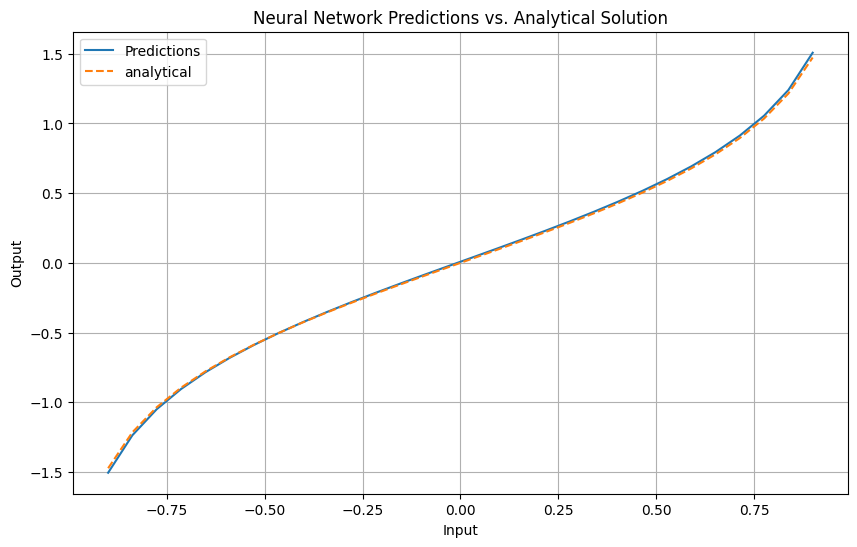

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(x_plot, y_pred, label='Predictions')
plt.plot(x_plot, y_anlt, label='analytical', linestyle='dashed')
plt.xlabel('Input')
plt.ylabel('Output')
plt.title('Neural Network Predictions vs. Analytical Solution')
plt.legend()
plt.grid(True)
plt.show()